/var/folders/tm/hjf14whs1xz0p1vxx3r7s95c0000gp/T/ipykernel_27779/260443084.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["migration"] = ndf["startLocation"] + "_" + ndf["endLocation"]


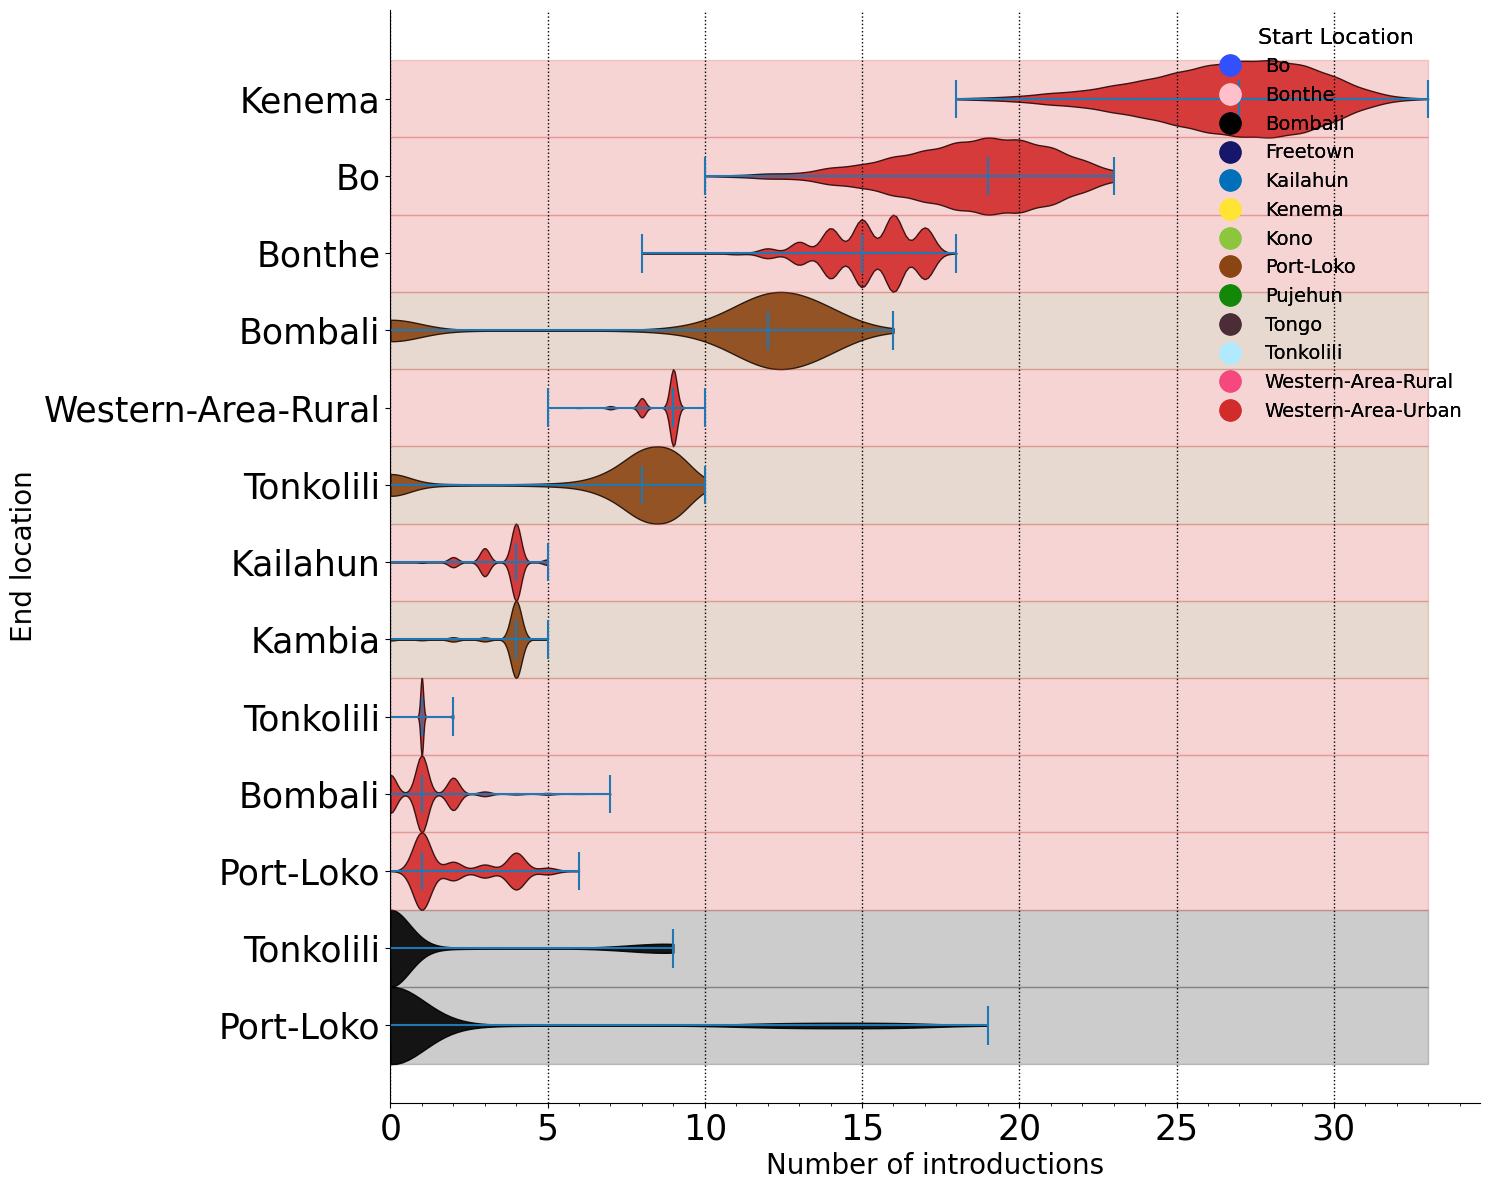

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from PyAstronomy import pyasl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# ────────────────────────────────────────────────────────────────
# Load data
# ────────────────────────────────────────────────────────────────
f = "/Volumes/Ifeanyi/CladeII_ML/SLE+MJhist.csv"
ldf = pd.read_csv(f)

# Convert decimal time to date
ldf["DD"] = [pyasl.decimalYearGregorianDate(float(xx), "yyyy-mm-dd") for xx in ldf["time"]]
ldf["year"] = [xx.split("-")[0] for xx in ldf["DD"]]
ldf["month"] = [xx.split("-")[1] for xx in ldf["DD"]]
ldf["cd"] = ldf["year"] + "-" + ldf["month"]

# Summarize counts
pdf = pd.DataFrame(ldf.groupby(["startLocation", "endLocation"])["treeId"].apply(list)).reset_index()
pdf["count"] = [len(x) for x in pdf["treeId"]]
pdf["mean"] = pdf["count"] / len(ldf["treeId"].unique())
pdf["distribution_counts"] = [list(pd.Series(x).value_counts().values) for x in pdf["treeId"]]
pdf = pdf.sort_values("mean", ascending=False)
pdf = pdf[pdf["mean"] >= 1]
pdf["startLocation"] = [s.title() for s in pdf["startLocation"]]
pdf["endLocation"] = [s.title() for s in pdf["endLocation"]]

# Prepare migration dictionary
ndf = pdf[["startLocation", "endLocation", "distribution_counts"]]
ndf["migration"] = ndf["startLocation"] + "_" + ndf["endLocation"]
DL = dict(zip(ndf["migration"], ndf["distribution_counts"]))

# Pad distribution counts
mx = max(len(v) for v in DL.values())
for k, v in DL.items():
    while len(v) < mx:
        v.append(0)
    DL[k] = [x if x >= 0 else 0 for x in v]

# Create data frame
data = pd.DataFrame(DL)

# ────────────────────────────────────────────────────────────────
# Plot settings
# ────────────────────────────────────────────────────────────────
mpl.rcParams['font.family'] = 'sans-serif'

# Region color dictionary
dd = {
    "Bo": "#3350FF",
    "Bonthe": "#FFC0CB",
    "Bombali":"black",
    "Freetown": "#16166B",
    "Kailahun": "#0070BB",
    "Kenema": "#FFE433",
    "Kono": "#8cc63f",
    "Port-Loko": "#8B4513",
    "Pujehun": "#138808",
    "Tongo": "#4c2d37",
    "Tonkolili": "#b1eaff",
    "Western-Area-Rural": "#f5487f",
    "Western-Area-Urban": "#D22B2B"
    
}

# Sort categories for plotting
categories = list(data.columns)
sorted_categories = sorted(categories, key=lambda x: data[x].median())
data_list = [data[cat] for cat in sorted_categories]

# ────────────────────────────────────────────────────────────────
# Create violin plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(15, 12))
violins = plt.violinplot(data_list, showmeans=False, showmedians=True, widths=1, vert=False)

# Extract start and end locations for coloring and axis labels
start_locations = [label.split('_')[0].title() for label in sorted_categories]
end_locations = [label.split('_')[1].title() for label in sorted_categories]

# Set y-ticks to only show end locations
plt.yticks(range(1, len(end_locations) + 1), end_locations, fontsize=25)

# Color the background bands by start location
yticks_locations = range(1, len(end_locations) + 1)
for ii, loc in enumerate(yticks_locations):
    region = start_locations[ii]
    color = dd.get(region, 'grey')
    plt.fill_between([0, max(max(v) for v in DL.values())], loc - 0.5, loc + 0.5, color=color, alpha=0.2)

# Color the violin bodies
for i, body in enumerate(violins['bodies']):
    region = start_locations[i]
    body.set_facecolor(dd.get(region, 'grey'))
    body.set_edgecolor('black')
    body.set_alpha(0.9)
# ────────────────────────────────────────────────────────────────
# Axis labels and title
# ────────────────────────────────────────────────────────────────
plt.ylabel('End location', fontsize=20)
plt.xlabel('Number of introductions', fontsize=20)
plt.title('', fontsize=18)

# Grid and styling
ax = plt.gca()
plt.grid(which='major', axis='x', linestyle=':', linewidth='1', color='black', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0)
plt.ylim(0)

# ────────────────────────────────────────────────────────────────
# Legend with color patches
# ────────────────────────────────────────────────────────────────


# Build legend handles for start locations
legend_lines = [
    mlines.Line2D(
        [], [], color=color, marker='o', markersize=15,  # slightly smaller for fitting
        linestyle='None', label=label
    )
    for label, color in dd.items()
]

# Create legend in upper right inside the figure
legend1 = ax.legend(
    handles=legend_lines,
    markerfirst=True,
    frameon=False,
    loc='upper right',          # <-- place legend inside the axes
    prop={'size': 14},
    title="Start Location",
    title_fontsize=16
)


# Add the legend as an artist so it remains visible if other legends are added
ax.add_artist(legend1)




plt.tight_layout()
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_results_MJ.png", bbox_inches='tight', dpi=300)
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_results_MJ.svg", bbox_inches='tight', dpi=300)
plt.show()

Rows after filter: 336160


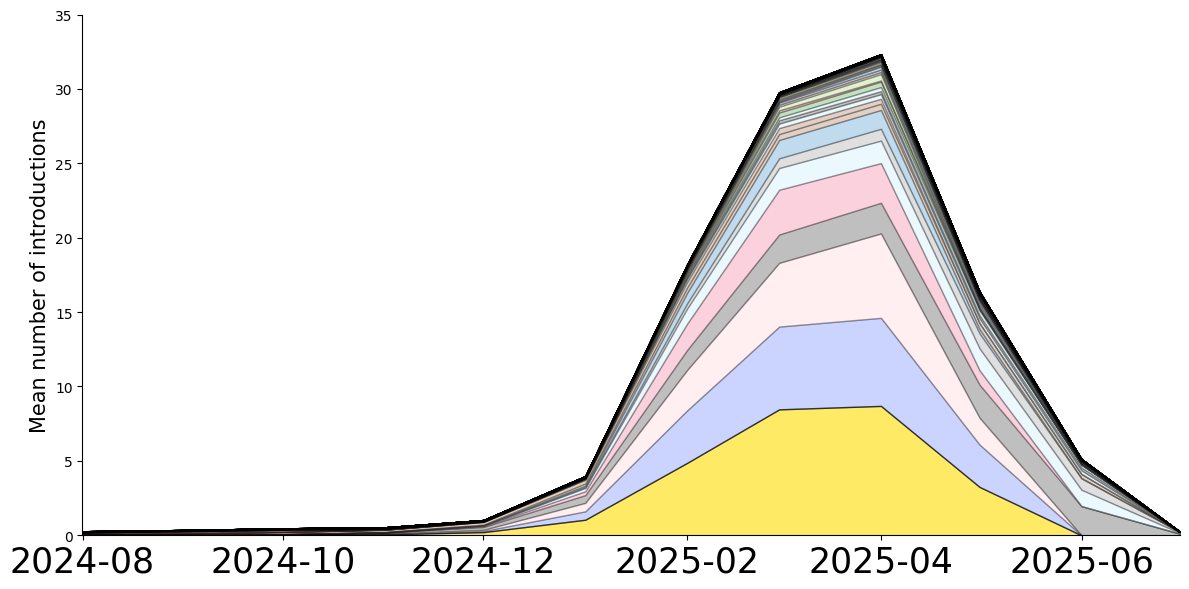

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import time
from datetime import datetime as dt
from PyAstronomy import pyasl

# ─────────────────────────────────────────────
# Helper: convert datetime → fractional year
# ─────────────────────────────────────────────
def toYearFraction(date):
    def sinceEpoch(date): 
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year + 1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    return year + yearElapsed / yearDuration

# Helper: convert fractional year → datetime for x-axis
def fracyear_to_datetime(fyear):
    year = int(fyear)
    remainder = fyear - year
    start_of_year = dt(year, 1, 1)
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    return start_of_year + pd.to_timedelta(remainder * days_in_year, unit="D")

# ─────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────
f = "/Volumes/Ifeanyi/CladeII_ML/SLE+MJhist.csv"
MT = pd.read_csv(f)

# Derive date components from decimal year
MT["DD"] = [pyasl.decimalYearGregorianDate(float(xx), "yyyy-mm-dd") for xx in MT["time"]]
MT["year"] = MT["DD"].str.split("-").str[0].astype(int)
MT["month"] = MT["DD"].str.split("-").str[1]
MT["cd"] = MT["year"].astype(str) + "-" + MT["month"].astype(str)

# Filter (adjust as needed)
MT = MT[(MT["year"] > 2024) | ((MT["year"] == 2024) & (MT["month"].astype(int) >= 8))]

print("Rows after filter:", len(MT))
if len(MT) == 0:
    print("No data after filter. Adjust the year filter.")
else:
    # ─────────────────────────────────────────────
    # Group and prepare
    # ─────────────────────────────────────────────
    pdf = MT.groupby(["startLocation", "endLocation", "cd"])["treeId"].apply(list).reset_index()
    pdf["count"] = pdf["treeId"].apply(len)
    pdf["mean"] = pdf["count"] / len(MT["treeId"].unique())
    pdf["C"] = pdf["startLocation"].str.lower() + "_" + pdf["endLocation"].str.lower()

    # Convert cd to datetime then fractional year
    pdf["cd"] = pd.to_datetime(pdf["cd"] + "-01")
    pdf["cd_frac"] = pdf["cd"].apply(toYearFraction)

    # Build data
    unique_times = np.sort(pdf["cd_frac"].unique())
    data = {}
    for cc in pdf["C"].unique():
        ndf = pdf[pdf["C"] == cc][["C", "mean", "cd_frac"]].copy()
        for t in unique_times:
            if t not in ndf["cd_frac"].values:
                ndf = pd.concat([ndf, pd.DataFrame({"C": [cc], "mean": [0], "cd_frac": [t]})], ignore_index=True)
        ndf = ndf.sort_values("cd_frac")
        data[cc] = ndf["mean"].to_numpy()
    data["time"] = unique_times

    # Replace NaNs
    for k in list(data.keys()):
        data[k] = np.nan_to_num(data[k])

    # Sort keys
    totals = {k: np.sum(v) for k, v in data.items() if k != "time"}
    sorted_keys = [k for k, _ in sorted(totals.items(), key=lambda x: x[1], reverse=True)]
    sorted_data = {k: data[k] for k in sorted_keys}

    # Convert fractional time to datetime for x-axis
    datetime_x = [fracyear_to_datetime(x) for x in data["time"]]

    # ─────────────────────────────────────────────
    # Color mapping
    # ─────────────────────────────────────────────
    dd = {
        "Bo": "#3350FF",
        "Bonthe": "#FFC0CB",
        "Bombali": "black",
        "Freetown": "#16166B",
        "Kailahun": "#0070BB",
        "Kenema": "#FFE433",
        "Kono": "#8cc63f",
        "Port-Loko": "#8B4513",
        "Pujehun": "#138808",
        "Tongo": "#4c2d37",
        "Tonkolili": "#b1eaff",
        "Western-Area-Rural": "#f5487f",
        "Western-Area-Urban": "#D22B2B"
    }
    mmap = {}  # add if you have special mappings

    # ─────────────────────────────────────────────
    # Plot
    # ─────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(12, 6))

    if sorted_keys:
        # First area
        first_k = sorted_keys[0]
        end_loc = re.sub("(.*)_", "", first_k).title()
        plt.fill_between(datetime_x, sorted_data[first_k],
                         color=dd.get(mmap.get(end_loc.lower(), end_loc), "grey"),
                         alpha=0.75, edgecolor="black")

        # Stacked areas
        for i, k in enumerate(sorted_keys[1:], start=1):
            end_loc = re.sub("(.*)_", "", k).title()
            lower = np.sum([sorted_data[u] for u in sorted_keys[:i]], axis=0)
            upper = np.sum([sorted_data[u] for u in sorted_keys[:i+1]], axis=0)
            plt.fill_between(datetime_x, lower, upper,
                             color=dd.get(mmap.get(end_loc.lower(), end_loc), "grey"),
                             alpha=0.25, edgecolor="black")

        # Axis styling with calendar year-month
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.ylabel('Mean number of introductions', fontsize=15)
        plt.ylim(0, 35)

        # Calendar date x-axis
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=0, ha='center', fontsize=25)

        plt.xlim(min(datetime_x), max(datetime_x))
        plt.tight_layout()
        plt.savefig("/Volumes/Ifeanyi/Timing_jumps.png", bbox_inches='tight', dpi=1000)
        plt.show()
    else:
        print("No migration keys found after filtering. Nothing to plot.")

In [2]:
import pandas as pd
import numpy as np

# ── 1. Load your migrations history CSV ────────────────────────────────────
CSV_PATH = "/Volumes/Ifeanyi/CladeII_ML/SLE+MJhist.csv"  # ← adjust this if needed
ldf = pd.read_csv(CSV_PATH)

# ── 2. Extract unique posterior samples and start locations ────────────────
tree_ids   = np.unique(ldf["treeId"])
start_locs = np.unique(ldf["startLocation"])

# ── 3. For each district, count introductions per sample and summarize ────
results = []
for loc in sorted(start_locs):
    # count, for each MCMC sample (treeId), how many jumps start at 'loc'
    counts = [
        ( (ldf["treeId"] == tid) & (ldf["startLocation"] == loc) ).sum()
        for tid in tree_ids
    ]
    median    = np.median(counts)
    lower, upper = np.percentile(counts, [2.5, 97.5])
    results.append({
        "District": loc.title(),
        "Median":  median,
        "95% HPD Lower": lower,
        "95% HPD Upper": upper
    })

# ── 4. Display results ─────────────────────────────────────────────────────
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

          District  Median  95% HPD Lower  95% HPD Upper
                Bo     0.0            0.0            3.0
           Bombali     0.0            0.0           31.0
            Bonthe     1.0            0.0            4.0
          Kailahun     0.0            0.0            2.0
            Kambia     0.0            0.0            2.0
            Kenema     1.0            0.0            4.0
         Koinadugu     0.0            0.0            3.0
              Kono     0.0            0.0            2.0
         Port-Loko    26.0            1.0           31.0
           Pujehun     0.0            0.0            2.0
             Tongo     0.0            0.0            2.0
         Tonkolili     0.0            0.0            3.0
Western-Area-Rural     0.0            0.0            2.0
Western-Area-Urban    79.0           69.0           87.0


In [4]:
import pandas as pd
import numpy as np

# ── 1. Load your annotated migrations history ───────────────────────────────
CSV_PATH = "/Volumes/Ifeanyi/CladeII_ML/SLE+MJhist.csv"  # ← adjust this path
ldf = pd.read_csv(CSV_PATH)

# ── 2. Build distribution of counts per migration per sample ────────────────
#    We assume 'treeId' labels your posterior samples (one per MCMC tree),
#    and that repeated treeId entries indicate multiple introductions.
pdf = (
    ldf
    .groupby(["startLocation", "endLocation"])["treeId"]
    .apply(list)
    .reset_index(name="tree_list")
)
pdf["counts"] = pdf["tree_list"].apply(lambda lst: pd.Series(lst).value_counts().tolist())

# Map each “start_end” to its per-sample counts
pdf["migration"] = pdf["startLocation"].str.title() + "_" + pdf["endLocation"].str.title()
dist_dict = dict(zip(pdf["migration"], pdf["counts"]))

# Pad all vectors to the same length
max_len = max(len(v) for v in dist_dict.values())
for k, v in dist_dict.items():
    dist_dict[k] = v + [0] * (max_len - len(v))

# ── 3. Sum all introductions *from* Western-Area-Urban per MCMC sample ────
#    i.e. for each posterior draw, how many total introductions started in WAU?
wau_keys = [k for k in dist_dict if k.startswith("Port-Loko")]
df_wau = pd.DataFrame({k: dist_dict[k] for k in wau_keys})
total_from_wau = df_wau.sum(axis=1)

# ── 4. Compute summary statistics ───────────────────────────────────────────
median = np.median(total_from_wau)
hpd_lower, hpd_upper = np.percentile(total_from_wau, [2.5, 97.5])

# ── 5. Print results ────────────────────────────────────────────────────────
print("Estimated total introductions originating from Western‑Area‑Urban:")
print(f"  • Median               = {median:.1f}")
print(f"  • 95% HPD interval     = [{hpd_lower:.1f}, {hpd_upper:.1f}]")

Estimated total introductions originating from Western‑Area‑Urban:
  • Median               = 26.0
  • 95% HPD interval     = [0.3, 33.0]


In [7]:
pdf=pd.DataFrame(ldf.groupby(["startLocation", "endLocation"])["treeId"].apply(list)).reset_index()
pdf["count"]=[len(x) for x in pdf["treeId"]]
pdf["mean"]=pdf["count"]/len(ldf["treeId"].unique())
pdf["distribution_counts"]=[list(pd.Series(x).value_counts().values) for x in pdf["treeId"]]
pdf=pdf.sort_values("mean", ascending=False)
pdf=pdf[pdf["mean"]>=1]
pdf["startLocation"]=[s.title() for s in pdf["startLocation"]]
pdf["endLocation"]=[s.title() for s in pdf["endLocation"]]

In [8]:
ndf=pdf[["startLocation", "endLocation", "distribution_counts"]]
ndf["distribution_counts"]=[x for x in ndf["distribution_counts"]]
ndf["migration"]=ndf["startLocation"]+"_"+ndf["endLocation"]
DL=dict(zip(ndf["migration"], ndf["distribution_counts"]))

mx=[]
for k,v in DL.items():
    mx.append(len(v))

mx=np.max(mx)

for k,v in DL.items():
    if len(v) < mx:
        v=v
        need=mx-len(v)
        for _ in range(need):
             v.append(0)
    v=[x if x >= 0 else 0 for x in v]
data = pd.DataFrame(DL)

data

/var/folders/tm/hjf14whs1xz0p1vxx3r7s95c0000gp/T/ipykernel_47207/798809343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["distribution_counts"]=[x for x in ndf["distribution_counts"]]
/var/folders/tm/hjf14whs1xz0p1vxx3r7s95c0000gp/T/ipykernel_47207/798809343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["migration"]=ndf["startLocation"]+"_"+ndf["endLocation"]


,Western-Area-Urban_Kenema,Western-Area-Urban_Bo,Western-Area-Urban_Bonthe,Port-Loko_Bombali,Western-Area-Urban_Western-Area-Rural,Port-Loko_Tonkolili,Port-Loko_Kambia,Western-Area-Urban_Kailahun,Bombali_Port-Loko,Western-Area-Urban_Port-Loko,Bombali_Tonkolili,Western-Area-Urban_Bombali,Western-Area-Urban_Tonkolili
0,33,23,18,16,10,10,5,5,19,6,9,7,2
1,33,23,18,16,10,10,5,5,18,6,9,6,2
2,32,23,18,16,10,10,5,5,18,6,9,6,2
3,32,23,18,16,10,10,4,5,18,6,9,6,2
4,32,23,18,16,10,10,4,5,18,6,9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,18,11,10,0,6,0,0,1,0,1,0,0,0
3090,18,11,10,0,6,0,0,1,0,1,0,0,0
3091,18,10,10,0,6,0,0,1,0,0,0,0,0
3092,18,10,9,0,6,0,0,1,0,0,0,0,0


(0.0, 14.15)

<Figure size 2000x2500 with 0 Axes>

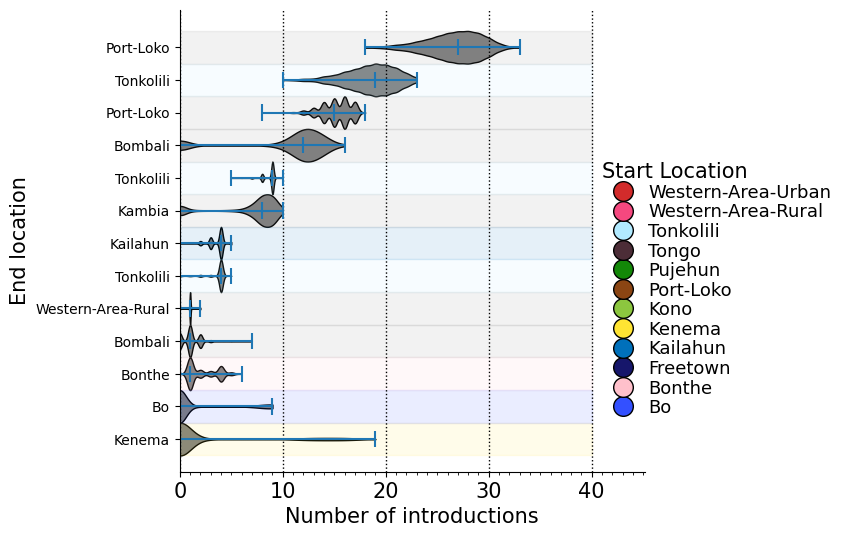

In [9]:
# Set default font
mpl.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(20, 25))
# Define colors for each region
dd = {
    "Bo": "#3350FF",
    "Bonthe": "#FFC0CB",
    "Freetown": "#16166B",
    "Kailahun": "#0070BB",
    "Kenema": "#FFE433",
    "Kono": "#8cc63f",
    "Port-Loko": "#8B4513",
    "Pujehun": "#138808",
    "Tongo": "#4c2d37",
    "Tonkolili": "#b1eaff",
    "Western-Area-Rural": "#f5487f",
    "Western-Area-Urban": "#D22B2B"
}

# Assuming 'data' is predefined DataFrame with appropriate data
categories = list(data.columns)
sorted_categories = sorted(categories, key=lambda x: data[x].median())
data_list = [data[cat] for cat in sorted_categories]

plt.figure(figsize=(6, 6))
violins = plt.violinplot(data_list, showmeans=False, showmedians=True, widths=1, vert=False)
plt.yticks(range(1, len(categories) + 1), sorted_categories)

# Reverse labels to match color assignment
labels = [item.get_text() for item in plt.gca().get_yticklabels()]
labels.reverse()
start_location = [re.sub('_(.*)', '', label) for label in labels]
new_labels = [re.sub('(.*)_', '', label) for label in labels]
plt.gca().set_yticklabels(new_labels)

yticks_locations, yticks_labels = plt.yticks()

for ii in range(len(yticks_locations)):
    loc = yticks_locations[ii]
    lab = yticks_labels[ii].get_text().lower()
    # Extract region from label and get corresponding color
    region = re.sub('_(.*)', '', lab).capitalize()
    color = dd.get(region, 'grey')  # Default to grey if region not found
    plt.fill_between([0, 40], loc - 0.5, loc + 0.5, color=color, alpha=0.1)

for i, body in enumerate(violins['bodies']):
    # Set violin color
    region = start_location[i].capitalize()
    body.set_facecolor(dd.get(region, 'grey'))  # Default to grey if region not found
    body.set_edgecolor('black')
    body.set_alpha(1)

plt.ylabel('End location', fontsize=15)
plt.xlabel('Number of introductions', size=15)
plt.title('')


# Legend
uu, yy = 43, 2
for k, v in dd.items():
    plt.scatter(uu, yy, s=200, color=v, zorder=400, edgecolor='black')
    plt.text(uu+2.5, yy-0.2, k, size=13)
    yy += 0.6  

plt.text(41, 9, "Start Location", size=15)

# Styling
ax = plt.gca()
plt.grid(which='major', axis='x', linestyle=':', linewidth='1', color='black', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.xticks(fontsize=15)
plt.xlim(0)
plt.ylim(0)
#plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_results_MJ.png", bbox_inches='tight', dpi=1000)
#plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_results_MJ.svg", bbox_inches='tight', dpi=1000)